In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
cali = fetch_california_housing()
df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
df['target'] = cali['target']
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [5]:
data = torch.from_numpy(df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([20640, 8]), torch.Size([20640, 1]))

In [6]:
ratios = [0.6, 0.2, 0.2]

In [7]:
train_cnt = int(X.shape[0] * ratios[0])
valid_cnt = int(X.shape[0] * ratios[1])
test_cnt = X.shape[0] - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[12384, 4128, 4128]

In [8]:
indices = torch.randperm(data.size(0))
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

In [9]:
for X_i, y_i in zip(X, y):
    print(X_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


In [13]:
scaler = StandardScaler()
scaler.fit(X[0].numpy())
X[0] = torch.from_numpy(scaler.transform(X[0].numpy())).float()
X[1] = torch.from_numpy(scaler.transform(X[1].numpy())).float()
X[2] = torch.from_numpy(scaler.transform(X[2].numpy())).float()

In [14]:
model = nn.Sequential(
    nn.Linear(X[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1))
)
optimizer = optim.Adam(model.parameters())

In [15]:
n_epochs = 3000
batch_size = 256
print_interval = 300

In [16]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf
early_stop = 100

In [17]:
train_history, valid_history = [], []

In [18]:
for i in range(n_epochs):
    indices = torch.randperm(X[0].shape[0])
    X_ = torch.index_select(X[0], dim=0, index=indices).split(batch_size, dim=0)
    y_ = torch.index_select(y[0], dim=0, index=indices).split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 300: train loss=0.345637, valid loss=0.346808, lowest loss=0.346083
Epoch 600: train loss=0.344661, valid loss=0.345797, lowest loss=0.343643
There is no improvement during last 100 epochs.
The best validation loss from epoch 522: 0.343643


<All keys matched successfully>

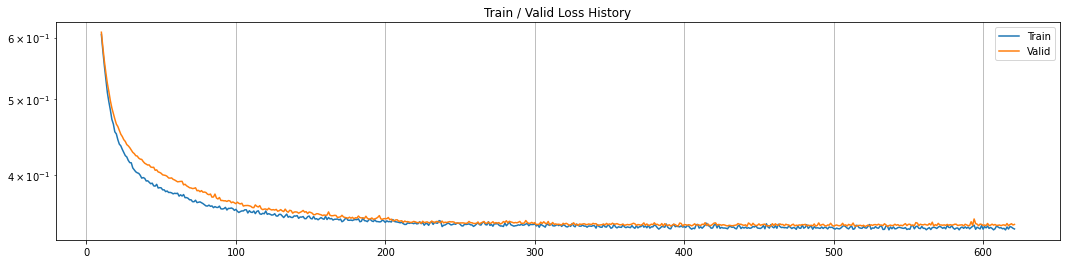

In [20]:
plot_from = 10

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [23]:
test_loss = 0
y_hat = []

with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.6f}')
print(f'Valid loss: {sorted_history[0][1]:.6f}')
print(f'Test loss: {test_loss:.6f}')

Train loss: 0.342273
Valid loss: 0.343643
Test loss: 0.341138
